# Project 4: Kinjal Sakhida and Meenakshi Tiwary Kleiman

The HAM10000 dataset comprises 10015 dermatoscopic images of skin lesions collected over 20 years from the Medical University of Vienna, Austria, and a skin cancer practice in Queensland, Australia. (https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

### Lesion Types in the Dataset
The dataset includes following skin lesion types:
    1. AKIEC: Actinic keratoses/intraepithelial carcinoma
    2. BCC: Basal cell carcinoma
    3. BKL: Benign keratosis-like lesions
    4. DF: Dermatofibroma
    5. MEL: Melanoma
    6. NV: Melanocytic nevi
    7. VC: Vascular lesions
    
### Aims
    1. Analyse dataset
    2. Develop an machine learning techniques for the classification of dermatoscopic images into categories such as melanoma, nevi, and other non-melanocytic pigmented lesions.


In [99]:
#Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import year, round, avg, col

In [144]:
#Load CSV files
metadata_path = "Resources/HAM10000_metadata.csv"
image_data_path = "Resources/hmnist_28_28_RGB.csv"

#Read the CSVs into the DataFrames
metadata = pd.read_csv(metadata_path)
images = pd.read_csv(image_data_path)



In [3]:
# Display the first few rows
metadata.head()


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
# Display the first few rows
images.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [5]:
# Number of images in each category
type_count = images.groupby('label').size()
type_count


label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
dtype: int64

In [6]:
# Define the dictionary for mapping abbreviations to full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# Display the first few rows of the metadata DataFrame
metadata.head()

# Convert abbreviations in the 'dx' column to full names
metadata['lesion_type'] = metadata['dx'].map(lesion_type_dict)

# Display the updated metadata DataFrame
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                     lesion_type  
0  Benign keratosis-like lesions  
1  Benign keratosis-like lesions  
2  Benign keratosis-like lesions  
3  Benign keratosis-like lesions  
4  Benign keratosis-like lesions

In [7]:
#Check the missing values if any
missing_values = metadata[metadata['dx'].isna()]
print(missing_values)


Empty DataFrame
Columns: [lesion_id, image_id, dx, dx_type, age, sex, localization, lesion_type]
Index: []


# Dataset analysis
    #1. Distribution of lesion type in the data set
    #2. Distribution of lesion type in male vs female
    #3. Distribution of lesion type in different age groups
    #4. Localization of Lesion type in differnt body parts of male and feamle

### 1. Distribution of lesion type in the data set 

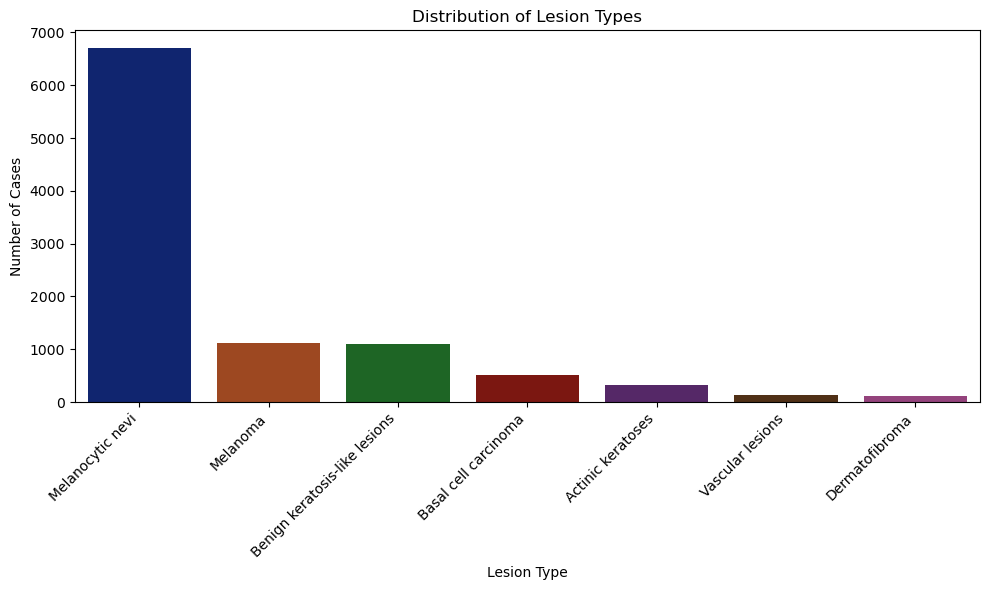

In [8]:
# Count occurrences of each lesion type
lesion_counts = metadata['lesion_type'].value_counts().reset_index()
lesion_counts.columns = ['Lesion Type', 'Number of Cases']

# Plot the bar chart with a bright color palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Lesion Type', y='Number of Cases', data=lesion_counts, palette='dark')
plt.title('Distribution of Lesion Types')
plt.xlabel('Lesion Type')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 2. Distribution of lesion type in male vs female 

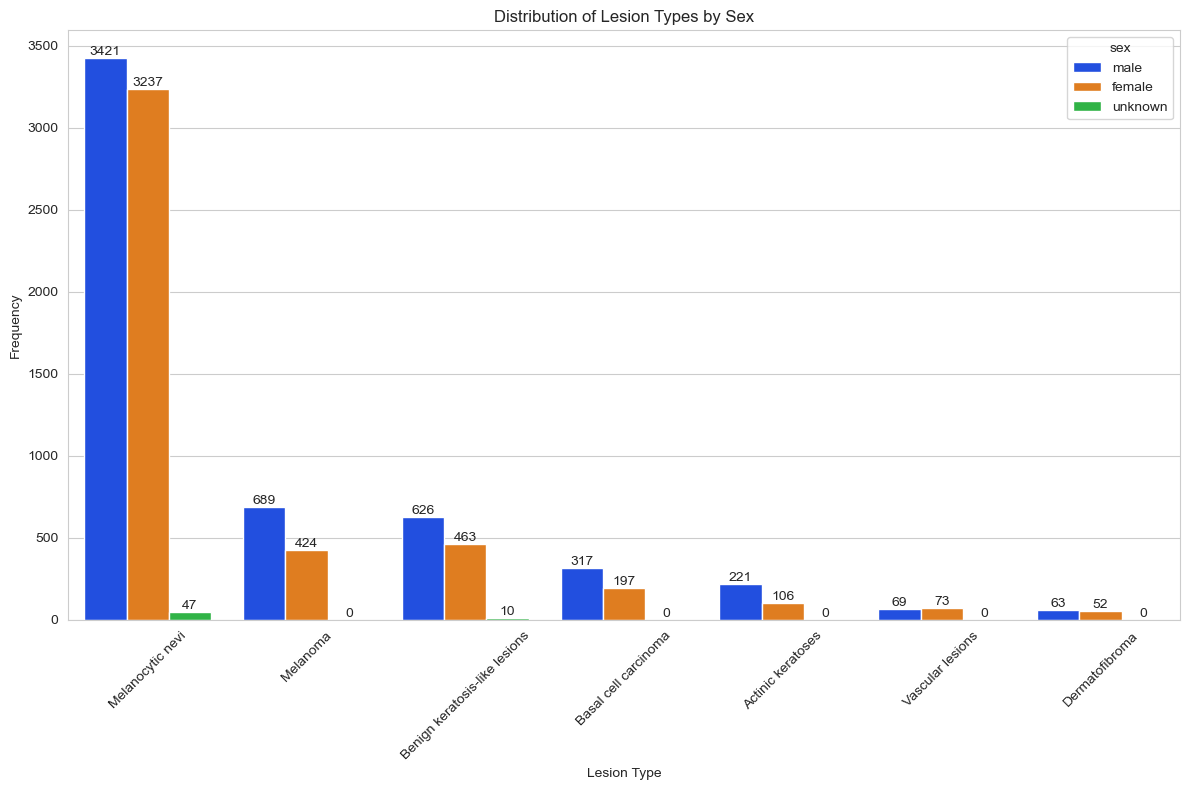

In [9]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the count of lesions by sex with a bright color palette
sns.countplot(x='lesion_type', hue='sex', data=metadata, palette='bright', ax=ax, order=metadata['lesion_type'].value_counts().index)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

# Set the title and labels
plt.title('Distribution of Lesion Types by Sex')
plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### 3. Distribution of lesion type in different age groups 

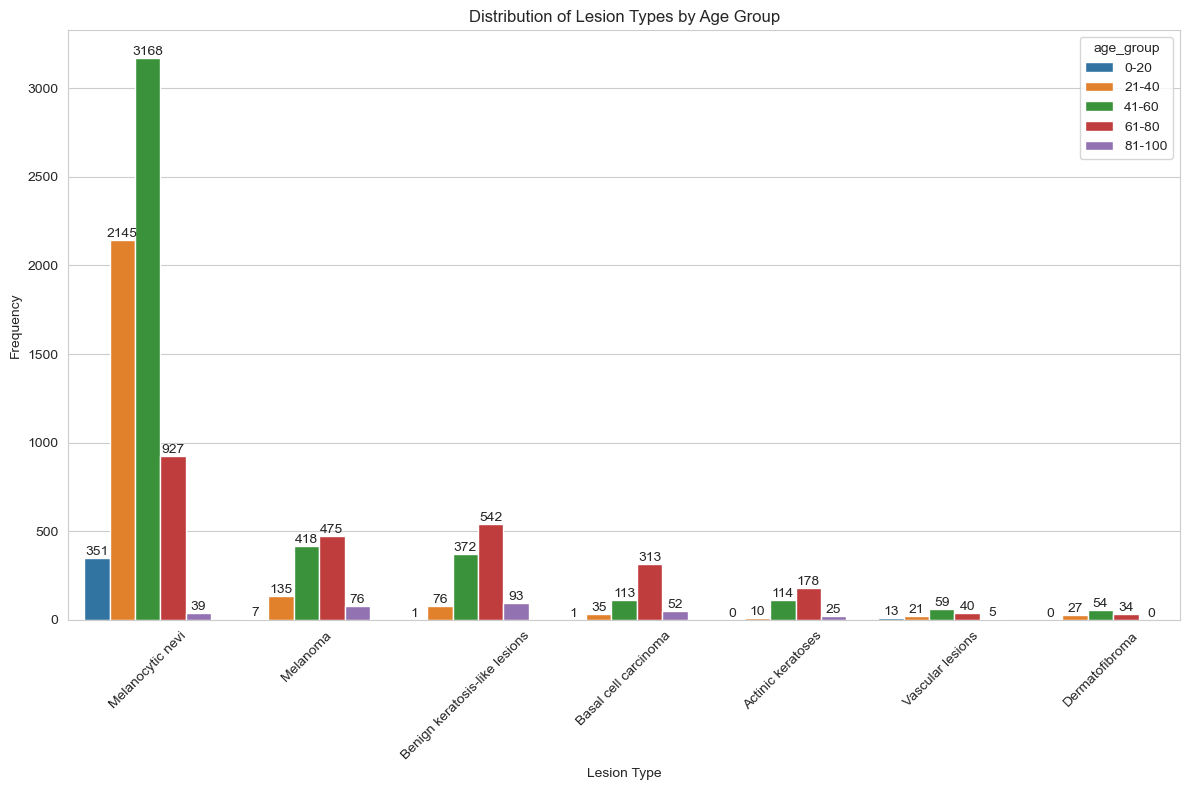

In [10]:
# Set the style of the visualization
sns.set_style("whitegrid")

# Create age groups
age_bins = pd.cut(metadata['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])
metadata['age_group'] = age_bins

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the count of lesions by age group with a bright color palette
sns.countplot(x='lesion_type', hue='age_group', data=metadata, palette='tab10', ax=ax, order=metadata['lesion_type'].value_counts().index)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

# Set the title and labels
plt.title('Distribution of Lesion Types by Age Group')
plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### 4. Localization of Lesion type in differnt body parts of male and feamle 

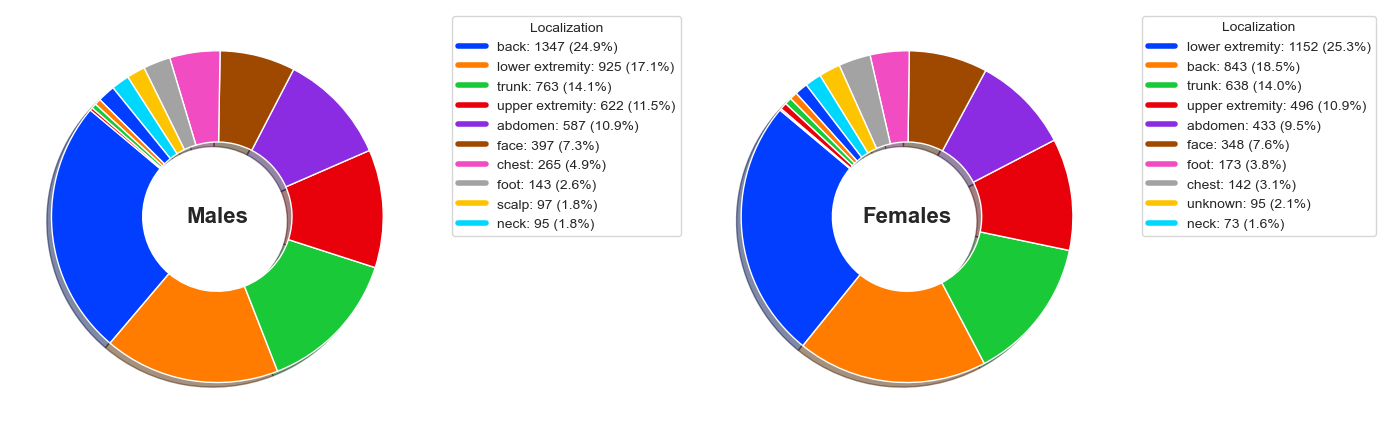

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_style("whitegrid")

# Prepare data for donut charts (example, replace with actual data)
male_localization = metadata[metadata['sex'] == 'male']['localization'].value_counts()
female_localization = metadata[metadata['sex'] == 'female']['localization'].value_counts()

# Function to create a donut chart with a 3D effect (including percentages in the legend)
def create_3d_donut_chart(ax, data, title):
    # Create the donut chart with shadow to simulate depth
    wedges, texts = ax.pie(
        data,
        colors=sns.color_palette('bright'),  # Use a bright color palette
        startangle=140,
        wedgeprops=dict(width=0.55, edgecolor='w'),  # Width of the donut and white edge
        labels=None,
        shadow=True  # Add shadow for 3D effect
    )
    
    # Adding a label to the center of the donut
    ax.text(0, 0, title, ha='center', va='center', fontsize=16, weight='bold')
    
    # Adding a legend outside the donut chart
    total = data.sum()  # Calculate the total for percentage calculation
    legend_labels = [f'{label}: {data[label]} ({data[label]/total*100:.1f}%)' for label in data.index]
    
    ax.legend(
        handles=[plt.Line2D([0], [0], color=color, lw=4) for color in sns.color_palette('bright')],
        labels=legend_labels,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        title='Localization'
    )

# Create figure with two subplots for donut charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Donut chart for males with 3D effect (including percentages in the legend)
create_3d_donut_chart(axes[0], male_localization, 'Males')

# Donut chart for females with 3D effect (including percentages in the legend)
create_3d_donut_chart(axes[1], female_localization, 'Females')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


####     1. Distribution of lesion type in the data set
       The maximum number of images belong to Melanocytic nevi, while the minimum number of images are from  Dermatofibroma.
       This highlights that Melanocytic nevi are the most common lesion type captured in the dataset, whereas Dermatofibroma is the least frequent.

####    2. Distribution of lesion type in male vs female
       Both genders show a relatively similar distribution across different lesion types, suggesting that gender does not strongly influence the occurrence of different lesions in this dataset.
####    3. Distribution of lesion type in different age groups
       Age groups between 20 and 80 exhibit the highest variety of lesion types.
####    4. Localization of Lesion type in differnt body parts of male and feamle
       Males: The majority of skin lesions are localized on the back. Females: Most skin lesions are found on the lower extremities.

In [13]:
# Preprocessing image data
# Drop 'label' from the image data for clustering purposes
X = images.drop('label', axis=1)

# Normalize data
X = X / 255.0  # Scale pixel values to range [0, 1] assuming original range [0, 255]

# Normalize the image data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Combine back with labels 
images_scaled = pd.DataFrame(X_scaled, columns=images.columns[:-1])  # Add pixel columns
images_scaled['label'] = images['label']  # Reattach the label column


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

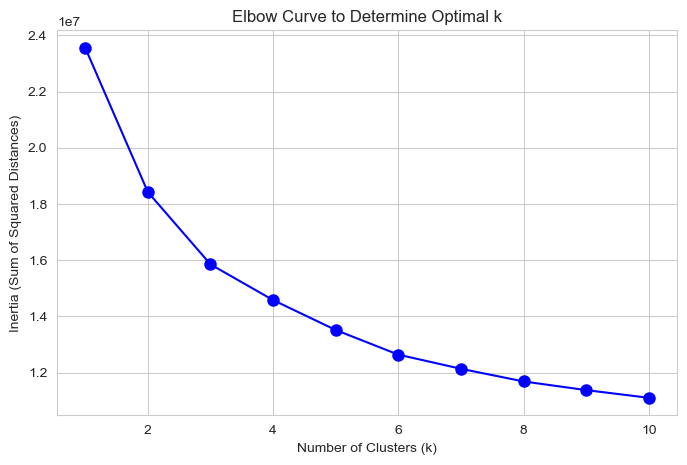

In [14]:
# List to store the inertia values (sum of squared distances)
inertia = []

# Range of k values to try (1 to 10 clusters, you can increase if needed)
k_values = range(1, 11)

# Fit KMeans with different numbers of clusters and record the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # Assuming X_scaled is your scaled dataset
    inertia.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Curve to Determine Optimal k')
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
2    3864
0    3368
1    2783
Name: count, dtype: int64


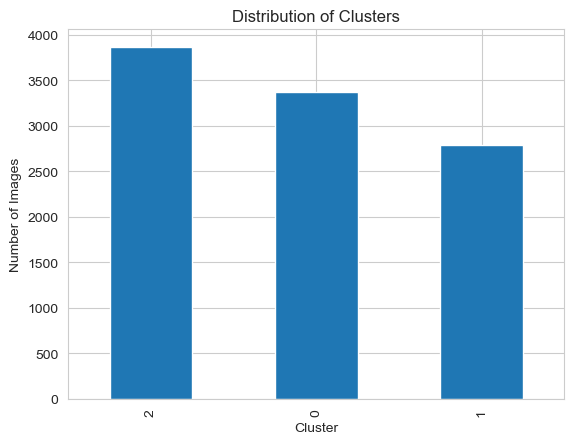

In [15]:
# Initialize K-Means with 3 clusters 
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model
kmeans.fit(X_scaled)

# Get the cluster labels
clusters = kmeans.labels_

# Add the clusters as a column in your images DataFrame
images['cluster'] = clusters

# View the distribution of clusters
print(images['cluster'].value_counts())

# Optionally, visualize the distribution of clusters
images['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Distribution of Clusters')
plt.show()

In [18]:
# How many images are in each cluster?
print(images['cluster'].value_counts())

# Example: If needed, you can perform additional analysis on clusters within the `images` DataFrame
# For example, exploring the distribution of labels within each cluster
print(images.groupby('cluster')['label'].value_counts())


cluster
2    3864
0    3368
1    2783
Name: count, dtype: int64
cluster  label
0        4        2919
         6         187
         2         137
         0          47
         5          31
         1          27
         3          20
1        4        1291
         2         622
         6         542
         1         160
         0         111
         3          34
         5          23
2        4        2495
         6         384
         2         340
         1         327
         0         169
         5          88
         3          61
Name: count, dtype: int64


# Plot Confusion Matrix and Conflict Matrix to evaluate the performance of clustering and classification models.



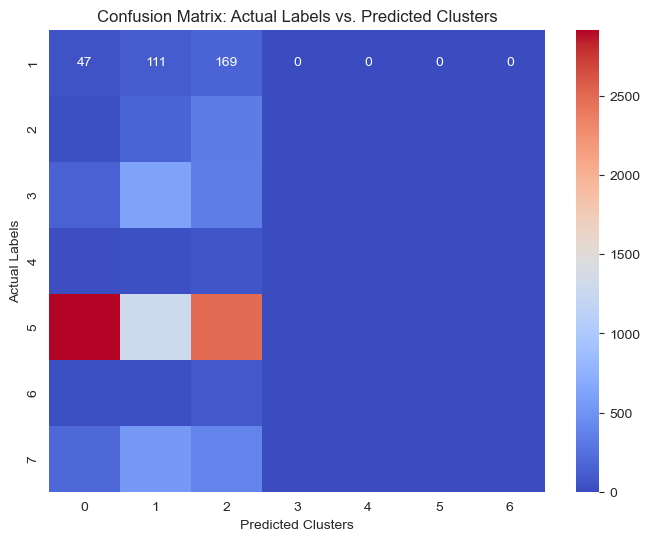

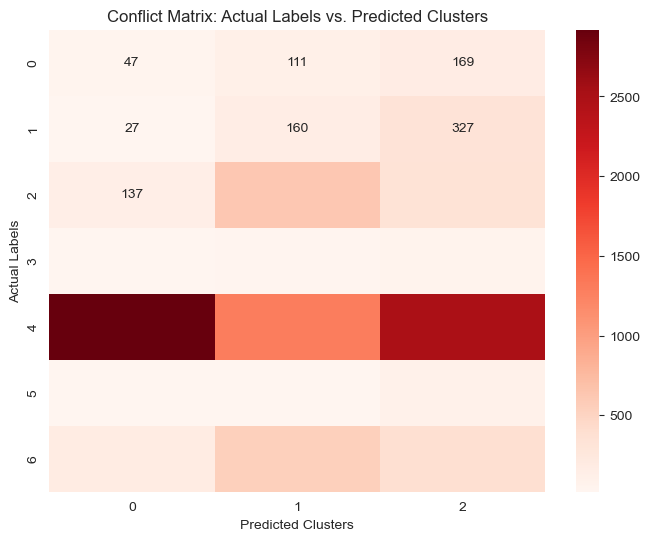

In [27]:

# Confusion Matrix
conf_matrix = confusion_matrix(images['label'], images['cluster'], labels=[0, 1, 2, 3, 4, 5, 6])

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0, 1, 2, 3, 4, 5, 6], yticklabels=[1, 2, 3, 4, 5, 6, 7])
plt.title('Confusion Matrix: Actual Labels vs. Predicted Clusters')
plt.xlabel('Predicted Clusters')
plt.ylabel('Actual Labels')
plt.show()

# Conflict Matrix
# Here, we define conflicts where actual labels and cluster assignments differ
conflict_matrix = pd.crosstab(images['label'], images['cluster'])

# Plotting Conflict Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conflict_matrix, annot=True, cmap='Reds', fmt='d')
plt.title('Conflict Matrix: Actual Labels vs. Predicted Clusters')
plt.xlabel('Predicted Clusters')
plt.ylabel('Actual Labels')
plt.show()



### Calculate ARI score

In [28]:
from sklearn.metrics import adjusted_rand_score

# Calculate ARI
ari = adjusted_rand_score(images['label'], images['cluster'])
print(f'Adjusted Rand Index: {ari}')


Adjusted Rand Index: 0.055960554452747724


### Plot t-SNE and calculate ARI value

Adjusted Rand Index for Hierarchical Clustering: 0.1572228756704822


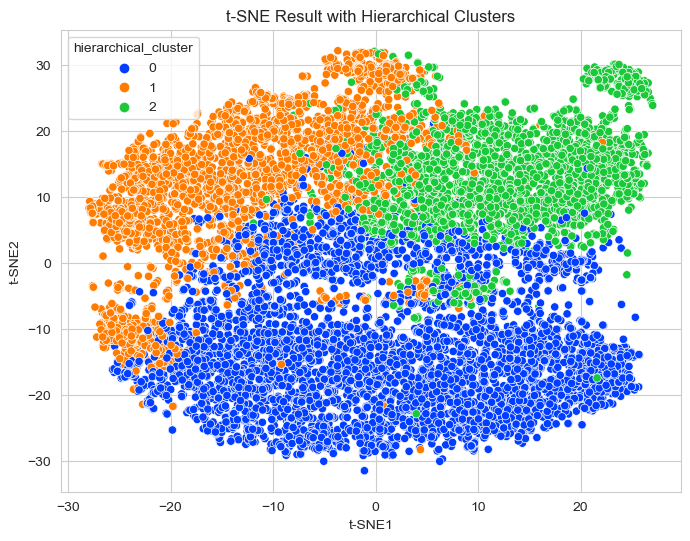

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Perform Agglomerative Clustering (Hierarchical Clustering)
hierarchical_clustering = AgglomerativeClustering(n_clusters=3)  # Adjust n_clusters as necessary
images['hierarchical_cluster'] = hierarchical_clustering.fit_predict(X_scaled)

# Perform t-SNE to reduce to 2 components for visualization
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=500)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame
images['t-SNE1'] = X_tsne[:, 0]
images['t-SNE2'] = X_tsne[:, 1]

# Calculate ARI for Hierarchical Clustering
ari_hierarchical = adjusted_rand_score(images['label'], images['hierarchical_cluster'])
print(f'Adjusted Rand Index for Hierarchical Clustering: {ari_hierarchical}')

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='hierarchical_cluster', data=images, palette='bright')
plt.title('t-SNE Result with Hierarchical Clusters')
plt.show()

## Unsupervised Machine Learning

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
# --- Load Metadata ---
metadata_path = "Resources/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_path)

# Define mapping of lesion type codes to full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Map lesion types in metadata
metadata['lesion_type'] = metadata['dx'].map(lesion_type_dict)

# Create a dictionary mapping filenames to labels
label_dict = pd.Series(metadata.lesion_type.values, index=metadata.image_id).to_dict()


In [ ]:
# --- Image Loading and Preprocessing ---
def load_image(filepath):
    img = Image.open(filepath).resize((64, 64))  # Resize images
    img_array = np.array(img) / 255.0  # Normalize image
    return img_array.flatten()  # Flatten for easier use in models like SVM

# Collect all filenames from the directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename.replace('.jpg', ''))
    return filenames

directories = ["Resources/HAM10000_images_part_1", "Resources/HAM10000_images_part_2"]
all_filenames = get_filenames_from_directories(directories)
# Load images and their corresponding labels
X_images, y_labels = [], []
for filename in all_filenames:
    if filename in label_dict:
        for directory in directories:
            filepath = os.path.join(directory, f'{filename}.jpg')
            if os.path.isfile(filepath):
                X_images.append(load_image(filepath))
                y_labels.append(label_dict[filename])
                break

# Convert lists to NumPy arrays
X = np.array(X_images)
y = np.array(y_labels)

In [ ]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# --- Encode Labels ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# --- Model Training and Evaluation ---
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, labels=range(len(label_encoder.classes_)))
    recall = recall_score(y_test, y_pred, average=None, labels=range(len(label_encoder.classes_)))
    
    print(f"Accuracy: {accuracy:.2f}")
    return precision, recall

# Logistic Regression Model
logistic_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logistic_precision, logistic_recall = train_and_evaluate_model(logistic_model, X_train, y_train_encoded, X_test, y_test_encoded)

# Random Forest Model
rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))
rf_precision, rf_recall = train_and_evaluate_model(rf_model, X_train, y_train_encoded, X_test, y_test_encoded)

# SVM Model
svm_model = make_pipeline(StandardScaler(), SVC())
svm_precision, svm_recall = train_and_evaluate_model(svm_model, X_train, y_train_encoded, X_test, y_test_encoded)


In [ ]:
# --- Plot Precision and Recall ---
def plot_precision_recall(precision, recall, model_name):
    precision_recall_df = pd.DataFrame({
        'Class': label_encoder.classes_,
        'Precision': precision,
        'Recall': recall
    })
    
    positions = range(len(precision_recall_df))
    plt.figure(figsize=(12, 6))
    plt.bar([p - 0.2 for p in positions], precision_recall_df['Precision'], width=0.4, label='Precision', color='blue')
    plt.bar([p + 0.2 for p in positions], precision_recall_df['Recall'], width=0.4, label='Recall', color='orange')
    plt.title(f'Precision and Recall by Class - {model_name}')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(ticks=positions, labels=precision_recall_df['Class'], rotation=45)
    plt.legend()
    plt.show()

# Plot precision and recall for models
plot_precision_recall(logistic_precision, logistic_recall, "Logistic Regression")
plot_precision_recall(rf_precision, rf_recall, "Random Forest")
plot_precision_recall(svm_precision, svm_recall, "SVM")

In [ ]:
# --- Dimensionality Reduction using PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# PCA Visualization
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label_encoder.transform(y), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Lesion Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Image Data')
plt.show()

In [ ]:
# --- Dimensionality Reduction using t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)

# t-SNE Visualization
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label_encoder.transform(y), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Lesion Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Image Data')
plt.show()

In [24]:
# Impute missing age with the median value
median_age = metadata['age'].median()
metadata['age'].fillna(median_age, inplace=True)

# Impute missing age_group with the most frequent value
most_frequent_age_group = metadata['age_group'].mode()[0]
metadata['age_group'].fillna(most_frequent_age_group, inplace=True)

In [25]:
# Verify that there are no more missing values
print(metadata.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
lesion_type     0
age_group       0
dtype: int64


**Train-Test Split**

In [29]:
from sklearn.model_selection import train_test_split

# Ensure the correct columns are used
file_paths = metadata['image_id'].values
labels = metadata['lesion_type'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

In [30]:
print(X_train[:5])


['ISIC_0032041' 'ISIC_0028254' 'ISIC_0030428' 'ISIC_0024888'
 'ISIC_0034237']


In [31]:
print(X_test[:5])


['ISIC_0030645' 'ISIC_0033634' 'ISIC_0031739' 'ISIC_0030581'
 'ISIC_0027415']


**Use Scikit-Learn for Image Classification**

In [32]:
import os

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]


# Get all filenames from the image directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename)
    return filenames

files_in_directory = get_filenames_from_directories(directories)


In [33]:
test_limit = 100  # Adjust as needed

# Check for missing files in X_train
missing_files = [filename for filename in X_train[:test_limit] if f'{filename}.jpg' not in files_in_directory]
print("Missing files in X_train:", missing_files)

# Check for missing files in X_test
missing_files_test = [filename for filename in X_test[:test_limit] if f'{filename}.jpg' not in files_in_directory]
print("Missing files in X_test:", missing_files_test)
    

Missing files in X_train: []
Missing files in X_test: []


In [34]:
# Skip missing files in X_train
for filename in X_train[:test_limit]:
    if filename in missing_files:
        print(f"Skipping missing file: {filename}")
        continue
    file_found = False
    for directory in directories:
        full_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(full_path):
            print(f"Processing: {full_path}")
            file_found = True
            break
    if not file_found:
        print(f"File not found: {filename}")

# Skip missing files in X_test
for filename in X_test[:test_limit]:
    if filename in missing_files_test:
        print(f"Skipping missing file: {filename}")
        continue
    file_found = False
    for directory in directories:
        full_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(full_path):
            print(f"Processing: {full_path}")
            file_found = True
            break
    if not file_found:
        print(f"File not found: {filename}")


Processing: Resources/HAM10000_images_part_2/ISIC_0032041.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0028254.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0030428.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0024888.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0034237.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0024713.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0027657.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0028221.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0031707.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0031742.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0026987.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0027720.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0032859.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0032070.jpg
Processing: Resources/HAM10000_images_part_2/ISIC_0031861.jpg
Processing: Resources/HAM10000_images_part_1/ISIC_0026898.jpg
Processi

In [35]:
# Create a dictionary to map filenames to labels
# Assuming 'image_id' is the column with filenames and 'lesion_type' is the column with full labels
label_dict = pd.Series(metadata.lesion_type.values, index=metadata.image_id).to_dict()

# Print some sample entries
print("Sample label_dict entries:", list(label_dict.items())[:10])

Sample label_dict entries: [('ISIC_0027419', 'Benign keratosis-like lesions'), ('ISIC_0025030', 'Benign keratosis-like lesions'), ('ISIC_0026769', 'Benign keratosis-like lesions'), ('ISIC_0025661', 'Benign keratosis-like lesions'), ('ISIC_0031633', 'Benign keratosis-like lesions'), ('ISIC_0027850', 'Benign keratosis-like lesions'), ('ISIC_0029176', 'Benign keratosis-like lesions'), ('ISIC_0029068', 'Benign keratosis-like lesions'), ('ISIC_0025837', 'Benign keratosis-like lesions'), ('ISIC_0025209', 'Benign keratosis-like lesions')]


In [36]:
import os
from PIL import Image
import numpy as np

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Collect all filenames from the image directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename.replace('.jpg', ''))
    return filenames

all_filenames = get_filenames_from_directories(directories)
print("Sample filenames:", all_filenames[:10])

# Preprocess function to load and resize images
def load_image(filepath):
    img = Image.open(filepath)
    img = img.resize((64, 64))  # Resize to 64x64 or any size you prefer
    img_array = np.array(img)   # Convert image to numpy array
    img_array = img_array.flatten() / 255.0  # Flatten and normalize
    return img_array

# Load all images and labels
X_train_images = []
y_train_labels = []

for filename in all_filenames:
    if filename in label_dict:
        # Process the image
        for directory in directories:
            full_path = os.path.join(directory, f'{filename}.jpg')
            if os.path.isfile(full_path):
                img_array = load_image(full_path)
                X_train_images.append(img_array)
                y_train_labels.append(label_dict[filename])
                break  # Exit loop once image is found

# Convert to numpy arrays
X_train_images = np.array(X_train_images)
y_train_labels = np.array(y_train_labels)

print("Processed images shape:", X_train_images.shape)
print("Processed labels shape:", y_train_labels.shape)


Sample filenames: ['ISIC_0026784', 'ISIC_0028971', 'ISIC_0026948', 'ISIC_0026790', 'ISIC_0028965', 'ISIC_0025299', 'ISIC_0024839', 'ISIC_0024811', 'ISIC_0026960', 'ISIC_0028795']
Processed images shape: (9919, 12288)
Processed labels shape: (9919,)


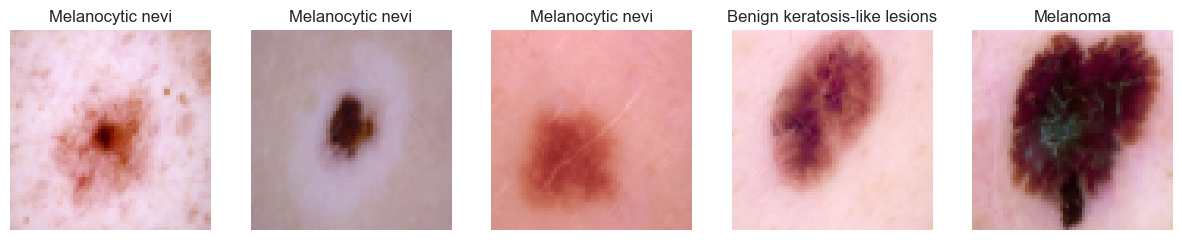

In [37]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Create a dictionary to map filenames to labels (assuming label_dict is already created)

def load_image(filename, directories):
    """Load and return an image given its filename and directories to search."""
    for directory in directories:
        image_path = os.path.join(directory, f'{filename}.jpg')
        if os.path.isfile(image_path):
            img = Image.open(image_path)
            img = img.resize((64, 64))  # Resize to speed up display
            return img
    return None

def display_images(filenames, labels, directories, num_images=5):
    """Display a sample of images with their labels."""
    plt.figure(figsize=(15, 10))

    # Preload images in parallel
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(lambda fname: load_image(fname, directories), filenames[:num_images]))

    for i in range(num_images):
        img = images[i]
        label = labels[i]
        
        plt.subplot(1, num_images, i + 1)
        if img is not None:
            plt.imshow(img)
        else:
            plt.imshow(np.zeros((64, 64, 3)))  # Placeholder if image not found
        plt.title(label)
        plt.axis('off')

    plt.show()

# Display a sample of images
num_images_to_display = 5
display_images(all_filenames, 
               [label_dict[filename] for filename in all_filenames[:num_images_to_display]],
               directories,
               num_images=num_images_to_display)


In [38]:
import os
from PIL import Image
import numpy as np
import pandas as pd

# Paths to image directories
directories = [
    "Resources/HAM10000_images_part_1",
    "Resources/HAM10000_images_part_2"
]

# Load metadata
metadata_path = "Resources/HAM10000_metadata.csv"
metadata = pd.read_csv(metadata_path)

# Define the dictionary for mapping abbreviations to full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Convert abbreviations in the 'dx' column to full names
metadata['lesion_type'] = metadata['dx'].map(lesion_type_dict)

# Create a dictionary to map filenames to labels
label_dict = pd.Series(metadata.lesion_type.values, index=metadata.image_id).to_dict()

# Collect all filenames from the image directories
def get_filenames_from_directories(directories):
    filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.jpg'):
                filenames.append(filename.replace('.jpg', ''))
    return filenames

all_filenames = get_filenames_from_directories(directories)

# Preprocess function to load and resize images
def load_image(filepath):
    img = Image.open(filepath)
    img = img.resize((64, 64))  # Resize to 64x64 or any size you prefer
    img_array = np.array(img)   # Convert image to numpy array
    img_array = img_array.flatten() / 255.0  # Flatten and normalize
    return img_array

# Load all images and labels
X_images = []
y_labels = []

for filename in all_filenames:
    if filename in label_dict:
        for directory in directories:
            full_path = os.path.join(directory, f'{filename}.jpg')
            if os.path.isfile(full_path):
                img_array = load_image(full_path)
                X_images.append(img_array)
                y_labels.append(label_dict[filename])
                break  # Exit loop once image is found

# Convert to numpy arrays
X = np.array(X_images)
y = np.array(y_labels)

print(f"Loaded {X.shape[0]} images.")


Loaded 10015 images.


In [39]:
from sklearn.model_selection import train_test_split

# Normalize the images
X = X / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (8012, 12288)
Testing data shape: (2003, 12288)


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Example: Load your image data and labels
# X, y = load_images_and_labels()  # Replace this with your actual data loading function

# Flatten images for SVM input
X_flat = X.reshape(X.shape[0], -1)

# Split data into training and test sets
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


**Different Classifiers:** Logistic Regression

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy: 0.64


<Figure size 1200x600 with 0 Axes>

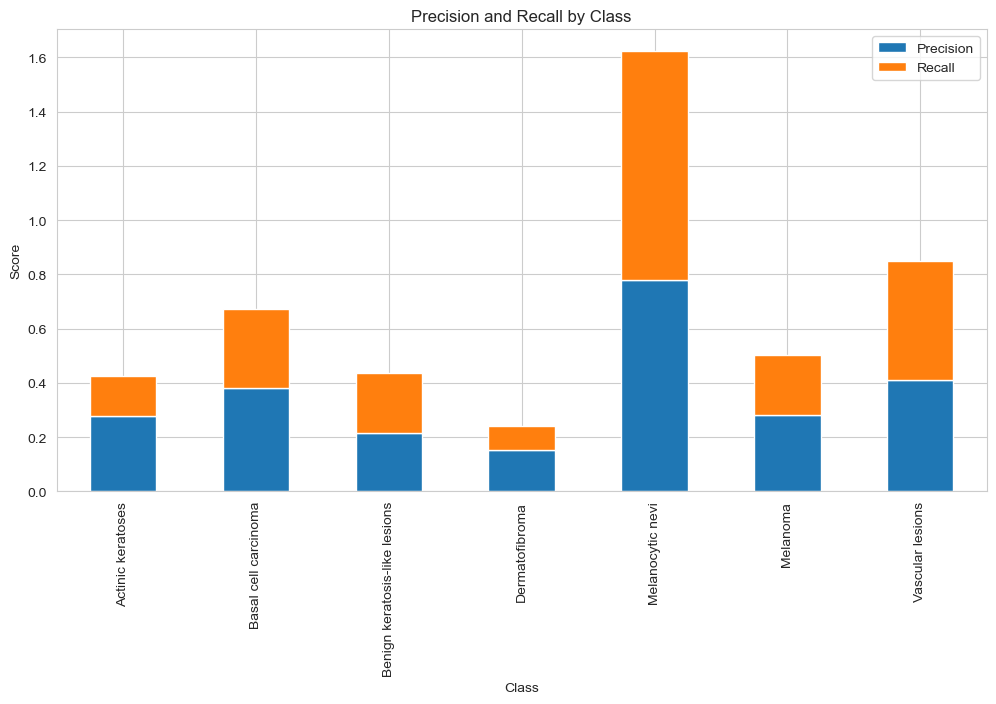

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score


# Ensure that X_train_flat, X_test_flat, y_train_encoded, and y_test_encoded are correctly defined and preprocessed

# Create a pipeline with scaling and Logistic Regression
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Train the model
model.fit(X_train_flat, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test_flat)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Compute precision and recall
precision = precision_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))
recall = recall_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))

# Create a DataFrame for easy plotting
precision_recall_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall
})

# Plot precision and recall
plt.figure(figsize=(12, 6))
precision_recall_df.plot(x='Class', kind='bar', stacked=True, figsize=(12, 6))
plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()

**Different Classifiers:** Random Forest

Test accuracy: 0.72


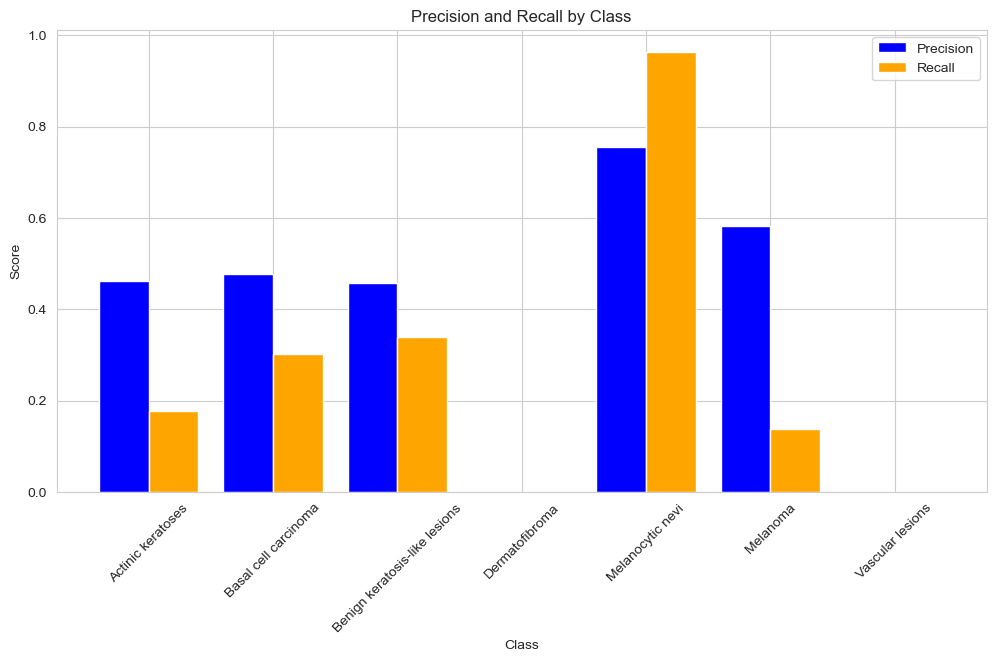

In [42]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train_flat, X_test_flat, y_train_encoded, y_test_encoded, and label_encoder are already defined

# Create a pipeline with scaling and Random Forest
model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))

# Train the model
model.fit(X_train_flat, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test_flat)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Compute precision and recall
precision = precision_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)), zero_division=0)
recall = recall_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)), zero_division=0)

# Create a DataFrame for easy plotting
precision_recall_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall
})

# Numeric positions for plotting
positions = range(len(precision_recall_df))

# Plot precision and recall
plt.figure(figsize=(12, 6))

# Plot precision
plt.bar([p - 0.2 for p in positions], precision_recall_df['Precision'], width=0.4, label='Precision', color='blue', align='center')
# Plot recall
plt.bar([p + 0.2 for p in positions], precision_recall_df['Recall'], width=0.4, label='Recall', color='orange', align='center')

plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(ticks=positions, labels=precision_recall_df['Class'], rotation=90)
plt.legend()
plt.show()


**Advance Analysis:**
Dimentionality Reduction For Classification (PCA)

Test accuracy: 0.70


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


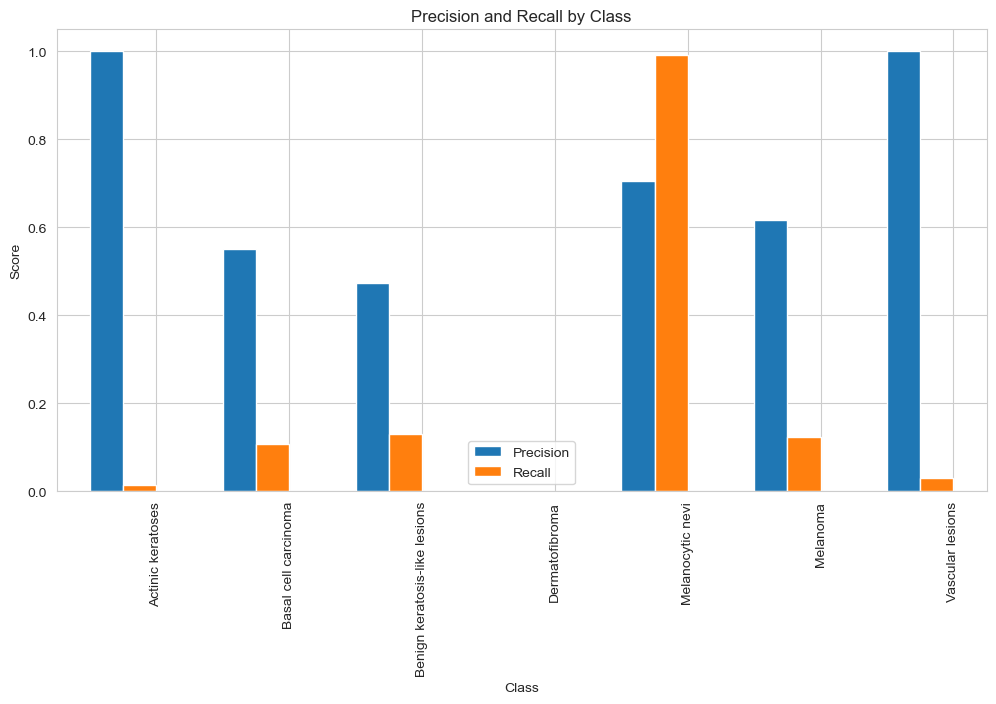

In [43]:
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score

# Reduce dimensions to 100 principal components
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Train and evaluate the model on PCA-transformed data
model.fit(X_train_pca, y_train_encoded)
y_pred = model.predict(X_test_pca)

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Compute precision and recall
precision = precision_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))
recall = recall_score(y_test_encoded, y_pred, average=None, labels=range(len(label_encoder.classes_)))

# Create a DataFrame for easy plotting
precision_recall_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall
})

# Plot precision and recall
precision_recall_df.plot(x='Class', kind='bar', figsize=(12, 6), position=1)
plt.title('Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()

**Advance Analysis:**
Dimentionality Reduction For Visualization (PCA)

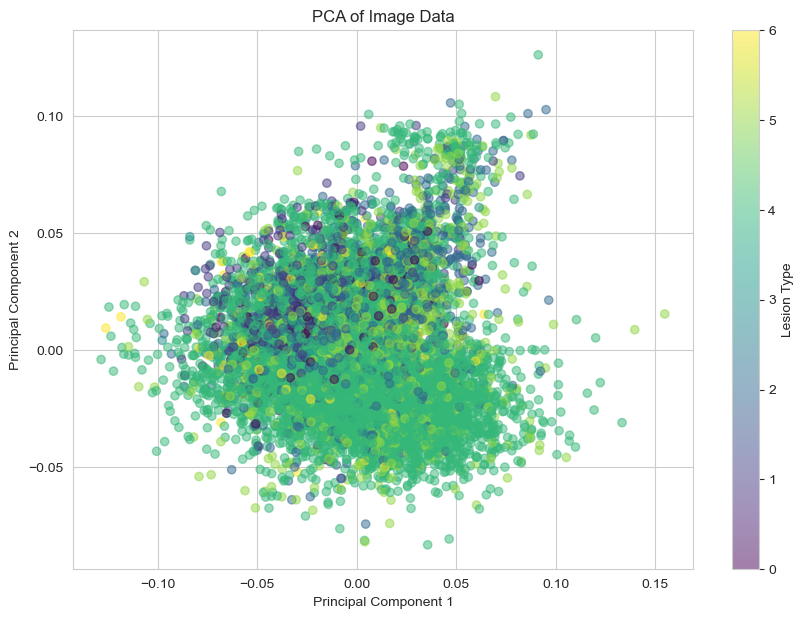

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


# Assuming X contains image data and y contains labels

# Encode categorical labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Reduce dimensions to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of PCA results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Lesion Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Image Data')
plt.show()


**t-SNE Technique** for Dimentionality Reduction 

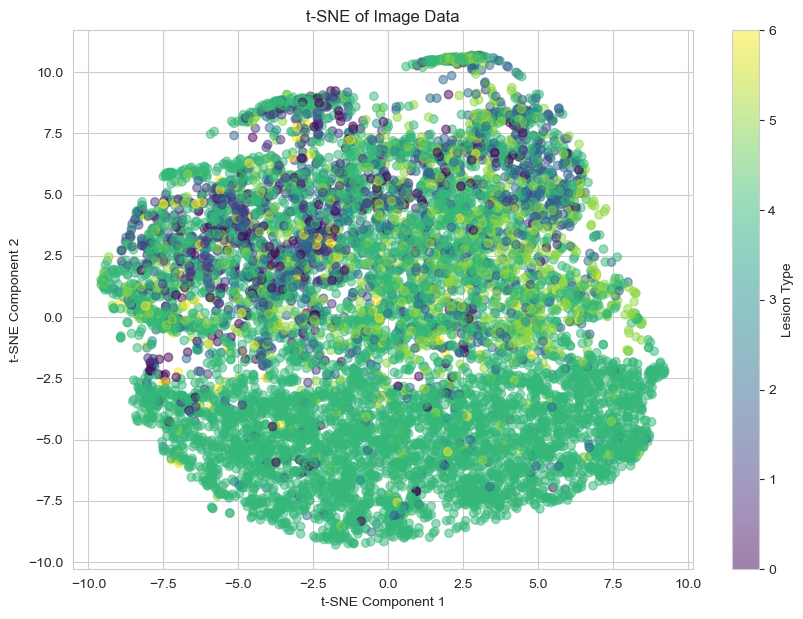

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Lesion Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Image Data')
plt.show()


**Feature Engineering:** Creating Additional Features

In [46]:
def extract_image_features(image_array):
    mean = np.mean(image_array)
    std_dev = np.std(image_array)
    return [mean, std_dev]

# Apply feature extraction
features = [extract_image_features(img) for img in X]
X_features = np.array(features)


**Model Comparison**

In [47]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Train and evaluate a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("RandomForest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Train and evaluate an SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))


RandomForest Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.45      0.21      0.28        68
         Basal cell carcinoma       0.54      0.32      0.40       103
Benign keratosis-like lesions       0.43      0.34      0.38       206
               Dermatofibroma       0.00      0.00      0.00        23
             Melanocytic nevi       0.76      0.96      0.85      1337
                     Melanoma       0.50      0.12      0.19       234
             Vascular lesions       0.00      0.00      0.00        32

                     accuracy                           0.71      2003
                    macro avg       0.38      0.28      0.30      2003
                 weighted avg       0.65      0.71      0.66      2003



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.35      0.09      0.14        68
         Basal cell carcinoma       0.47      0.32      0.38       103
Benign keratosis-like lesions       0.38      0.26      0.31       206
               Dermatofibroma       0.00      0.00      0.00        23
             Melanocytic nevi       0.74      0.97      0.84      1337
                     Melanoma       0.73      0.12      0.20       234
             Vascular lesions       0.00      0.00      0.00        32

                     accuracy                           0.70      2003
                    macro avg       0.38      0.25      0.27      2003
                 weighted avg       0.66      0.70      0.64      2003



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Convolutional neural network (CNN) for image classification


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Epoch 1/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6618 - loss: 1.1836 - val_accuracy: 0.6725 - val_loss: 0.9245
Epoch 2/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6677 - loss: 0.9474 - val_accuracy: 0.6906 - val_loss: 0.8742
Epoch 3/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6677 - loss: 0.9322 - val_accuracy: 0.6931 - val_loss: 0.9393
Epoch 4/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6826 - loss: 0.8593 - val_accuracy: 0.6875 - val_loss: 0.8416
Epoch 5/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6894 - loss: 0.8538 - val_accuracy: 0.6974 - val_loss: 0.8641
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6663 - loss: 0.9445
Test accuracy: 0.6849725246429443


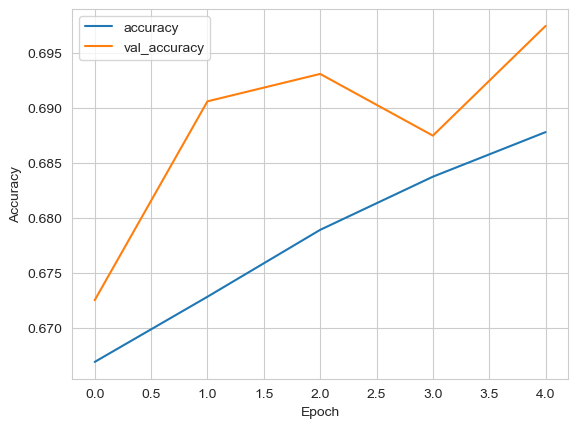

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load CSV files
metadata_path = "Resources/HAM10000_metadata.csv"
image_data_path = "Resources/hmnist_28_28_RGB.csv"

# Read the CSVs into the DataFrames
metadata = pd.read_csv(metadata_path)
images = pd.read_csv(image_data_path)

# Separate the labels and the pixel values
labels = images['label'].values  # Use 'images' instead of 'data'
images = images.drop(columns=['label']).values  # Drop the label column from 'images'

# Reshape the flattened images back to 28x28x3
images_reshaped = images.reshape(-1, 28, 28, 3)

# Normalize the image pixel values (0-255) to the range (0-1)
images_normalized = images_reshaped / 255.0

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=7)

# Define the model architecture
model = keras.Sequential([
    layers.InputLayer(input_shape=(28, 28, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Assuming 7 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model optimization by increasing epoch to 20 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6454 - loss: 1.1866 - val_accuracy: 0.6725 - val_loss: 0.9098
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6799 - loss: 0.9265 - val_accuracy: 0.6812 - val_loss: 0.8980
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6888 - loss: 0.8782 - val_accuracy: 0.6744 - val_loss: 0.8762
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6864 - loss: 0.8631 - val_accuracy: 0.6993 - val_loss: 0.7929
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6858 - loss: 0.8358 - val_accuracy: 0.7031 - val_loss: 0.8135
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7025 - loss: 0.8074 - val_accuracy: 0.6968 - val_loss: 0.7844
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6935 - loss: 0.8096 - val_accuracy: 0.7249 - val_loss: 0.7557
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7023 - loss: 0.7905 - val_acc

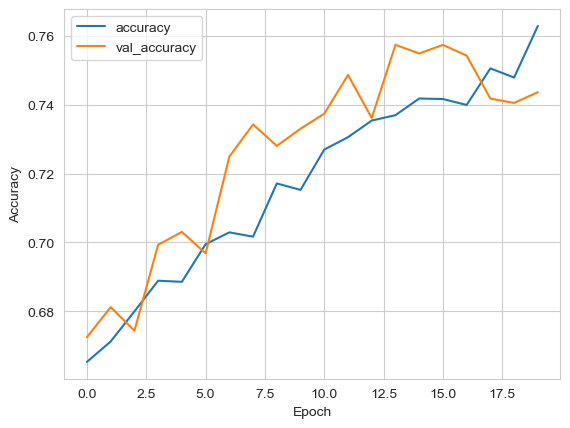

In [105]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load CSV files
metadata_path = "Resources/HAM10000_metadata.csv"
image_data_path = "Resources/hmnist_28_28_RGB.csv"

# Read the CSVs into the DataFrames
metadata = pd.read_csv(metadata_path)
images = pd.read_csv(image_data_path)

# Separate the labels and the pixel values
labels = images['label'].values  # Use 'images' instead of 'data'
images = images.drop(columns=['label']).values  # Drop the label column from 'images'

# Reshape the flattened images back to 28x28x3
images_reshaped = images.reshape(-1, 28, 28, 3)

# Normalize the image pixel values (0-255) to the range (0-1)
images_normalized = images_reshaped / 255.0

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=7)

# Define the model architecture
model = keras.Sequential([
    layers.InputLayer(input_shape=(28, 28, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Assuming 7 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


 ## Model optimization by increasing epoch to 100 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6414 - loss: 1.1908 - val_accuracy: 0.6737 - val_loss: 0.8948
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6741 - loss: 0.9244 - val_accuracy: 0.6831 - val_loss: 0.8565
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6775 - loss: 0.9050 - val_accuracy: 0.6837 - val_loss: 0.8415
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6759 - loss: 0.9105 - val_accuracy: 0.6931 - val_loss: 0.8567
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6865 - loss: 0.8611 - val_accuracy: 0.7006 - val_loss: 0.8782
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6982 - loss: 0.8406 - val_accuracy: 0.7105 - val_loss: 0.7918
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7010 - loss: 0.7988 - val_accuracy: 0.7087 - val_loss: 0.8098
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7117 - loss: 0.7891 

201/201 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.8870 - loss: 0.2919 - val_accuracy: 0.7486 - val_loss: 0.8256
Epoch 51/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8861 - loss: 0.2937 - val_accuracy: 0.7592 - val_loss: 0.9200
Epoch 52/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8787 - loss: 0.3098 - val_accuracy: 0.7586 - val_loss: 0.9384
Epoch 53/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8903 - loss: 0.2786 - val_accuracy: 0.7586 - val_loss: 0.9386
Epoch 54/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8938 - loss: 0.2673 - val_accuracy: 0.7598 - val_loss: 0.9127
Epoch 55/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8995 - loss: 0.2652 - val_accuracy: 0.7573 - val_loss: 0.9517
Epoch 56/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8898 - loss: 0.2774 - val_accuracy: 0.7542 - val_loss: 0.9762
Epoch 57/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8961 - loss: 0.2560 - va

201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9587 - loss: 0.1058 - val_accuracy: 0.7611 - val_loss: 1.7273
Epoch 100/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9506 - loss: 0.1284 - val_accuracy: 0.7511 - val_loss: 1.8534
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7514 - loss: 1.7603
Test accuracy: 0.7598602175712585


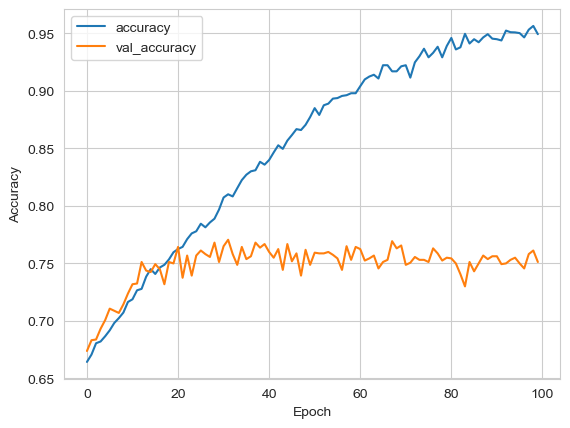

In [139]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load CSV files
metadata_path = "Resources/HAM10000_metadata.csv"
image_data_path = "Resources/hmnist_28_28_RGB.csv"

# Read the CSVs into the DataFrames
metadata = pd.read_csv(metadata_path)
images = pd.read_csv(image_data_path)

# Separate the labels and the pixel values
labels = images['label'].values  # Use 'images' instead of 'data'
images = images.drop(columns=['label']).values  # Drop the label column from 'images'

# Reshape the flattened images back to 28x28x3
images_reshaped = images.reshape(-1, 28, 28, 3)

# Normalize the image pixel values (0-255) to the range (0-1)
images_normalized = images_reshaped / 255.0

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=7)

# Define the model architecture
model = keras.Sequential([
    layers.InputLayer(input_shape=(28, 28, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Assuming 7 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Model prediction of skin lesion images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class: [0]


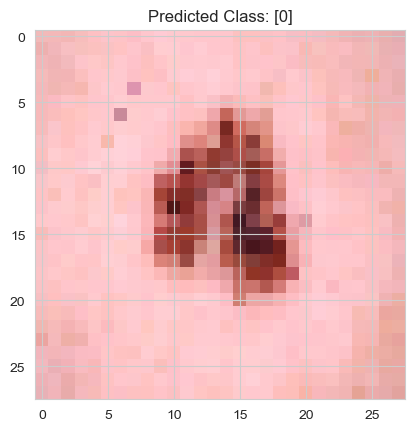

In [141]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File2.jpg"

# Load the image and resize it to (28, 28) as expected by the model
img = image.load_img(img_path, target_size=(28, 28))

# Convert the image to a numpy array and normalize the pixel values to (0, 1)
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match the input shape (1, 28, 28, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)

print(f'Predicted class: {predicted_class}')

# Optional: If you want to plot the image and prediction
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicted class: [4]


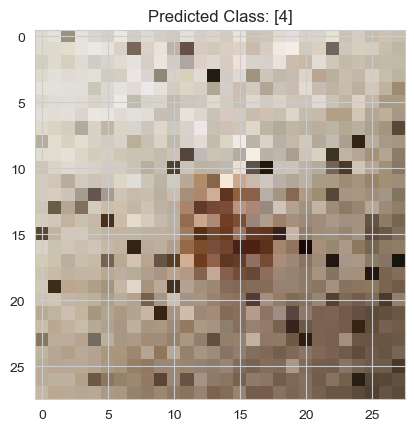

In [143]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File6.jpg"

# Load the image and resize it to (28, 28) as expected by the model
img = image.load_img(img_path, target_size=(28, 28))

# Convert the image to a numpy array and normalize the pixel values to (0, 1)
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match the input shape (1, 28, 28, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)

print(f'Predicted class: {predicted_class}')

# Optional: If you want to plot the image and prediction
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted class: [3]


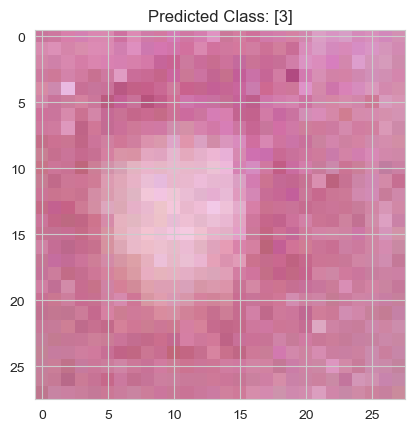

In [153]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File30.jpg"

# Load the image and resize it to (28, 28) as expected by the model
img = image.load_img(img_path, target_size=(28, 28))

# Convert the image to a numpy array and normalize the pixel values to (0, 1)
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match the input shape (1, 28, 28, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)

print(f'Predicted class: {predicted_class}')

# Optional: If you want to plot the image and prediction
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted class: [4]


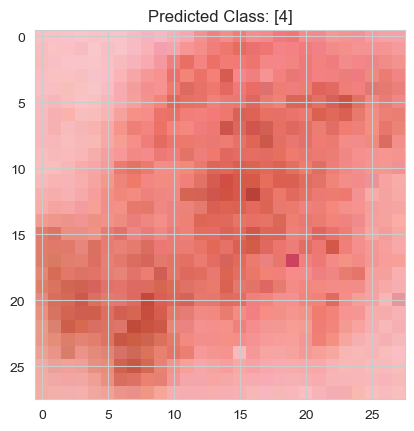

In [155]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File50.jpg"

# Load the image and resize it to (28, 28) as expected by the model
img = image.load_img(img_path, target_size=(28, 28))

# Convert the image to a numpy array and normalize the pixel values to (0, 1)
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match the input shape (1, 28, 28, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)

print(f'Predicted class: {predicted_class}')

# Optional: If you want to plot the image and prediction
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: [1]


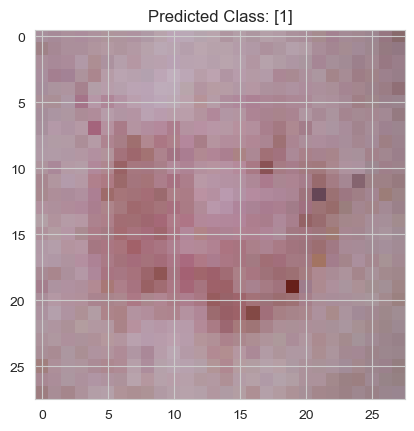

In [151]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File10.jpg"

# Load the image and resize it to (28, 28) as expected by the model
img = image.load_img(img_path, target_size=(28, 28))

# Convert the image to a numpy array and normalize the pixel values to (0, 1)
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match the input shape (1, 28, 28, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)

print(f'Predicted class: {predicted_class}')

# Optional: If you want to plot the image and prediction
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted class: [4]


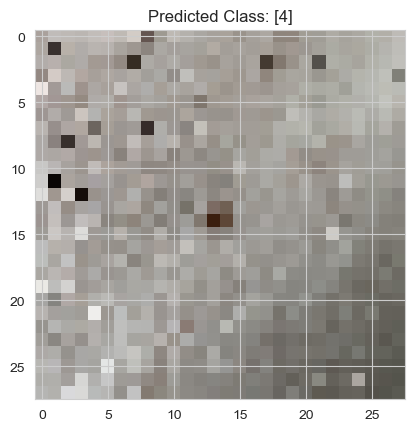

In [158]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File8.jpg"

# Load the image and resize it to (28, 28) as expected by the model
img = image.load_img(img_path, target_size=(28, 28))

# Convert the image to a numpy array and normalize the pixel values to (0, 1)
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match the input shape (1, 28, 28, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = model.predict(img_array)

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction, axis=1)

print(f'Predicted class: {predicted_class}')

# Optional: If you want to plot the image and prediction
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Epoch 1/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6452 - loss: 1.2280 - val_accuracy: 0.6719 - val_loss: 0.9425
Epoch 2/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.6726 - loss: 0.9698 - val_accuracy: 0.6781 - val_loss: 0.9178
Epoch 3/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6758 - loss: 0.9210 - val_accuracy: 0.6806 - val_loss: 0.8778
Epoch 4/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6707 - loss: 0.9105 - val_accuracy: 0.7056 - val_loss: 0.8435
Epoch 5/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6786 - loss: 0.8673 - val_accuracy: 0.7074 - val_loss: 0.8253
Epoch 6/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6804 - loss: 0.8834 - val_accuracy: 0.7049 - val_loss: 0.8175
Epoch 7/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6852 - loss: 0.8475 - val_accuracy: 0.7112 - val_loss: 0.7832
Epoch 8/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7060 - loss: 0.817

201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8259 - loss: 0.4440 - val_accuracy: 0.7567 - val_loss: 0.8229
Epoch 51/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8414 - loss: 0.3956 - val_accuracy: 0.7654 - val_loss: 0.8020
Epoch 52/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8368 - loss: 0.4038 - val_accuracy: 0.7723 - val_loss: 0.7431
Epoch 53/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8367 - loss: 0.4162 - val_accuracy: 0.7580 - val_loss: 0.8333
Epoch 54/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8487 - loss: 0.3789 - val_accuracy: 0.7604 - val_loss: 0.7770
Epoch 55/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8503 - loss: 0.3782 - val_accuracy: 0.7673 - val_loss: 0.7661
Epoch 56/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8475 - loss: 0.3815 - val_accuracy: 0.7580 - val_loss: 0.7969
Epoch 57/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8600 - loss: 0.3626 - val

201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9231 - loss: 0.1868 - val_accuracy: 0.7492 - val_loss: 1.3944
Epoch 100/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9277 - loss: 0.1856 - val_accuracy: 0.7492 - val_loss: 1.3941
Epoch 101/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9348 - loss: 0.1619 - val_accuracy: 0.7486 - val_loss: 1.3235
Epoch 102/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9318 - loss: 0.1667 - val_accuracy: 0.7405 - val_loss: 1.5208
Epoch 103/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9275 - loss: 0.1753 - val_accuracy: 0.7667 - val_loss: 1.4064
Epoch 104/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9311 - loss: 0.1726 - val_accuracy: 0.7667 - val_loss: 1.4148
Epoch 105/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9259 - loss: 0.1754 - val_accuracy: 0.7548 - val_loss: 1.3846
Epoch 106/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9288 - loss: 0.170

201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9566 - loss: 0.1173 - val_accuracy: 0.7598 - val_loss: 2.0330
Epoch 149/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9544 - loss: 0.1152 - val_accuracy: 0.7586 - val_loss: 2.0391
Epoch 150/150
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9516 - loss: 0.1204 - val_accuracy: 0.7567 - val_loss: 2.0411
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7409 - loss: 2.1237
Test accuracy: 0.7508736848831177


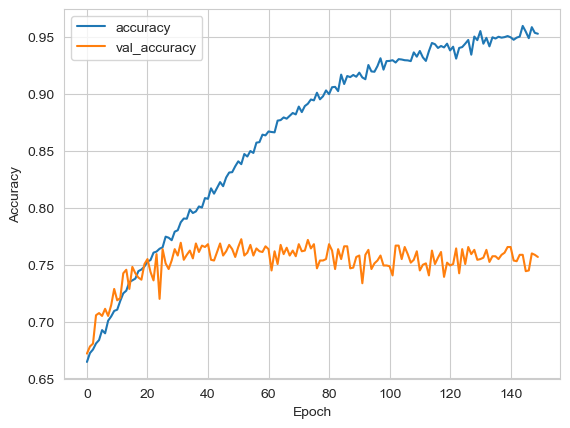

In [127]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load CSV files
metadata_path = "Resources/HAM10000_metadata.csv"
image_data_path = "Resources/hmnist_28_28_RGB.csv"

# Read the CSVs into the DataFrames
metadata = pd.read_csv(metadata_path)
images = pd.read_csv(image_data_path)

# Separate the labels and the pixel values
labels = images['label'].values  # Use 'images' instead of 'data'
images = images.drop(columns=['label']).values  # Drop the label column from 'images'

# Reshape the flattened images back to 28x28x3
images_reshaped = images.reshape(-1, 28, 28, 3)

# Normalize the image pixel values (0-255) to the range (0-1)
images_normalized = images_reshaped / 255.0

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=7)

# Define the model architecture
model = keras.Sequential([
    layers.InputLayer(input_shape=(28, 28, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Assuming 7 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=150, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Organize 10,015 images based on their class labels from CSV metadata file 

In [128]:
import os
import shutil
import pandas as pd

# Load metadata that contains 'image_id' and 'lesion_type' (class labels)
metadata = pd.read_csv('Resources/HAM10000_metadata.csv')

# Source directories where the images are currently located
source_dirs = ["Resources/HAM10000_images_part_1", "Resources/HAM10000_images_part_2"]

# Destination directory where we will create subdirectories for each class
destination_dir = "Resources/HAM10000_classified"

# Ensure the destination directory exists
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Group images by lesion_type (class) and move them to the corresponding subdirectory
for index, row in metadata.iterrows():
    image_name = row['image_id'] + ".jpg"  # Adjust the extension if necessary
    class_name = row['dx']  # Use 'dx' for class labels
    
    # Create a class-labeled subdirectory if it doesn't exist
    class_dir = os.path.join(destination_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    
    # Look for the image in both source directories
    source_path = None
    for source_dir in source_dirs:
        potential_path = os.path.join(source_dir, image_name)
        if os.path.exists(potential_path):
            source_path = potential_path
            break
    
    # If the image is found, move it to the class-labeled subdirectory
    if source_path:
        destination_path = os.path.join(class_dir, image_name)
        shutil.move(source_path, destination_path)
    else:
        print(f"Image {image_name} not found in {source_dirs}")



Image ISIC_0027419.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025030.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026769.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025661.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031633.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027850.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0029176.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0029068.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025837.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025209.

Image ISIC_0025964.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030623.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027190.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031023.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028086.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031177.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026993.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026120.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028412.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030417.

Image ISIC_0028548.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030512.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031718.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0029591.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030932.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028899.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0032036.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0024644.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031543.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027065.

Image ISIC_0031236.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030813.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026074.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027846.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0032174.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025940.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031266.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026056.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026156.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028937.

Image ISIC_0025877.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030509.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0024641.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026854.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0024860.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026529.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028711.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025806.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026364.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026267.

Image ISIC_0032403.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0029949.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025190.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030222.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026058.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031553.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028942.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028748.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025920.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027321.

Image ISIC_0026669.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0029110.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026095.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030628.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027445.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026990.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027395.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027207.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0025643.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027377.

Image ISIC_0032560.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0033427.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0033948.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0033680.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0033085.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0033976.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0034030.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0034179.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0034206.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0032980.

Image ISIC_0031871.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0029075.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028887.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0031567.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0028358.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0027766.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030809.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0032311.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0030920.jpg not found in ['Resources/HAM10000_images_part_1', 'Resources/HAM10000_images_part_2']
Image ISIC_0026401.

# Building, training, and evaluating a Convolutional Neural Network (CNN) using the TensorFlow/Keras framework on an image classification dataset. 

## Dataset: The dataset is loaded from a directory where images are stored in subfolders based on their class labels. It is split into training and validation datasets.
## Model:  Convolutional Neural Network (CNN) with two convolutional layers followed by max pooling, flattening, and fully connected layers. A dropout layer is added to prevent overfitting.
## Training: The model is trained for epochs using the Adam optimizer and evaluated using categorical cross-entropy loss and accuracy.
## Evaluation: The model's accuracy is evaluated on the validation set, and training/validation accuracy plot


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 943s 4s/step - accuracy: 0.6321 - loss: 1.6879 - val_accuracy: 0.6720 - val_loss: 0.9545
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.6671 - loss: 1.0049 - val_accuracy: 0.6715 - val_loss: 1.0059
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.6643 - loss: 0.9759 - val_accuracy: 0.6740 - val_loss: 0.8921
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - accuracy: 0.6725 - loss: 0.9143 - val_accuracy: 0.6740 - val_loss: 0.8675
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.6775 - loss: 0.8753 - val_accuracy: 0.6810 - val_loss: 0.8525
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 963ms/step - accuracy: 0.7034 - loss: 0.8084
Validation Accuracy: 0.68


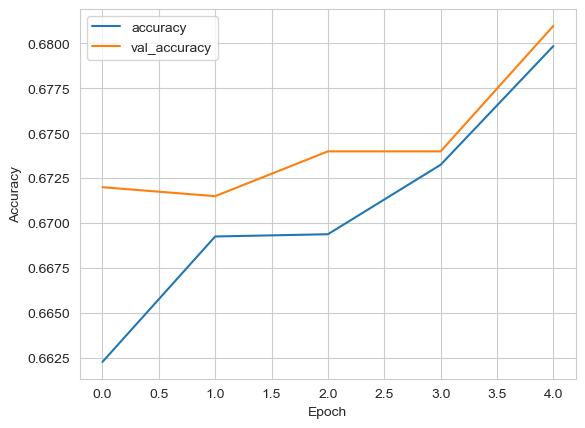

In [129]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

# Set the dataset directory path
directory = "Resources/HAM10000_classified"

# Load the dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",
    seed=123,
    image_size=(224, 224),  # Resize images to match model input (InceptionV3 uses 224x224)
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Define your model architecture
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_dataset.class_names), activation='softmax')  # Number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 1.Data augmentation using TensorFlow/Keras: Data augmentation is a technique used to artificially increase the size and diversity of a training dataset by applying random transformations to the input images. These transformations help the model generalize better by making it more robust to variations in the data, thus reducing overfitting. 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.6214 - loss: 1.5520 - val_accuracy: 0.6715 - val_loss: 0.9696
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.6672 - loss: 0.9871 - val_accuracy: 0.6715 - val_loss: 0.8765
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.6670 - loss: 0.9352 - val_accuracy: 0.6715 - val_loss: 0.8564
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.6641 - loss: 0.9242 - val_accuracy: 0.6760 - val_loss: 0.8318
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.6685 - loss: 0.8890 - val_accuracy: 0.6830 - val_loss: 0.8127
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 781ms/step - accuracy: 0.7046 - loss: 0.7644
Validation Accuracy: 0.68


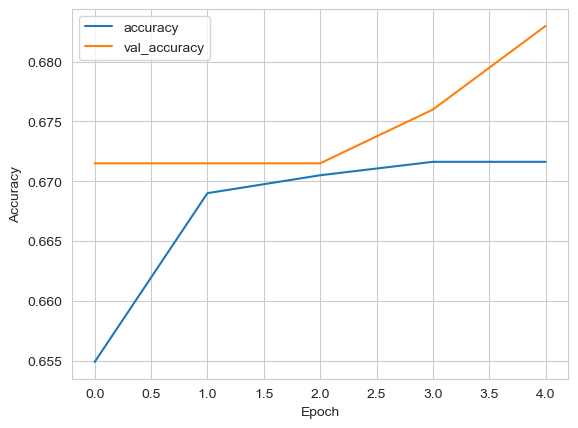

In [86]:
# Set up data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# Define model architecture with input shape in the first layer
model = Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Define input shape
    data_augmentation,  # Add data augmentation
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_dataset.class_names), activation='softmax')  # Number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Plot the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2. The InceptionV3 model is commonly used for image classification tasks, and by using a pre-trained model, we're leveraging the knowledge the model has already gained from training on the massive ImageNet dataset. 
(Note: nceptionV3 is a deep convolutional neural network designed for image classification. It was developed by Google and is part of the Inception architecture family. This architecture is known for being highly efficient in terms of computation and accuracy.)

In [87]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Define your model architecture using the pre-trained base model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce dimensions
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_dataset.class_names), activation='softmax')  # Number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 838s 3s/step - accuracy: 0.5703 - loss: 7.0326 - val_accuracy: 0.6715 - val_loss: 1.2697
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 810s 3s/step - accuracy: 0.6668 - loss: 1.3897 - val_accuracy: 0.6715 - val_loss: 1.3083
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 852s 3s/step - accuracy: 0.6652 - loss: 1.3246 - val_accuracy: 0.6715 - val_loss: 1.0927
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.6657 - loss: 1.2277 - val_accuracy: 0.6720 - val_loss: 1.0638
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.6666 - loss: 1.1748 - val_accuracy: 0.6720 - val_loss: 1.0374
63/63 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6896 - loss: 1.0026
Validation Accuracy: 0.67


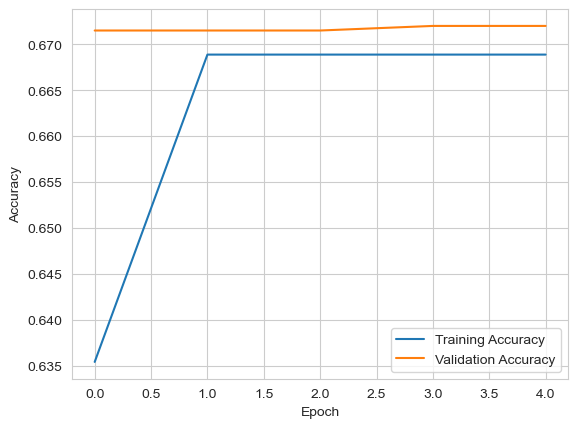

In [88]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt

# Set the dataset directory path
directory = "Resources/HAM10000_classified"

# Load the dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",
    seed=123,
    image_size=(224, 224),  # Resize images to match model input (InceptionV3 uses 224x224)
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Data Augmentation (optional)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# Load the InceptionV3 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Define your model architecture using the pre-trained base model
model = Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Define input shape
    data_augmentation,  # Add data augmentation
    base_model,  # Pre-trained InceptionV3 base model
    layers.GlobalAveragePooling2D(),  # Reduce dimensions
    layers.Dense(128, activation='relu'),  # Add a fully connected layer
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(len(train_dataset.class_names), activation='softmax')  # Number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 3. Complex model architecture 

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.6377 - loss: 1.3597 - val_accuracy: 0.6735 - val_loss: 0.9371
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.6691 - loss: 0.9495 - val_accuracy: 0.6760 - val_loss: 0.9206
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 720s 3s/step - accuracy: 0.6740 - loss: 0.9034 - val_accuracy: 0.6825 - val_loss: 0.8426
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 794s 3s/step - accuracy: 0.6809 - loss: 0.8664 - val_accuracy: 0.6925 - val_loss: 0.8581
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 966s 4s/step - accuracy: 0.6961 - loss: 0.8337 - val_accuracy: 0.7069 - val_loss: 0.8004
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7284 - loss: 0.7694
Validation Accuracy: 0.71


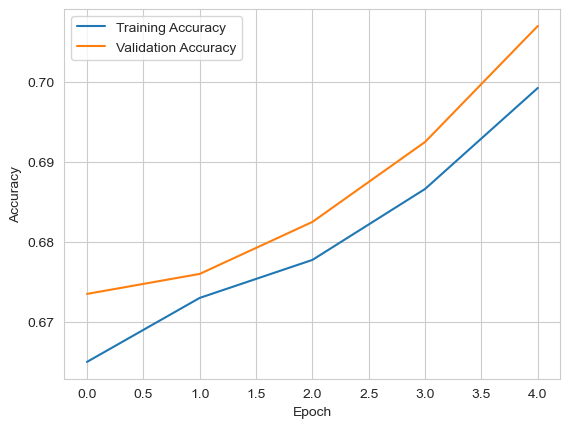

In [90]:
# Set the dataset directory path
directory = "Resources/HAM10000_classified"

# Load the dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",
    seed=123,
    image_size=(224, 224),  # Resize images to match model input (InceptionV3 uses 224x224)
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Data Augmentation (optional)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# Load the InceptionV3 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Define model architecture using the pre-trained base model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Added more filters
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased number of neurons
    layers.Dropout(0.5),
    layers.Dense(len(train_dataset.class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 4. Increasing epochs from 5 to 20

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 676s 3s/step - accuracy: 0.6417 - loss: 1.3267 - val_accuracy: 0.6735 - val_loss: 0.9311
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - accuracy: 0.6668 - loss: 0.9281 - val_accuracy: 0.6705 - val_loss: 0.9352
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 654s 3s/step - accuracy: 0.6727 - loss: 0.8969 - val_accuracy: 0.6890 - val_loss: 0.8552
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 658s 3s/step - accuracy: 0.6881 - loss: 0.8490 - val_accuracy: 0.7004 - val_loss: 0.7963
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.6935 - loss: 0.8093 - val_accuracy: 0.7049 - val_loss: 0.7927
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 664s 3s/step - accuracy: 0.7114 - loss: 0.7790 - val_accuracy: 0.7029 - val_loss: 0.7783
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.7132 - loss

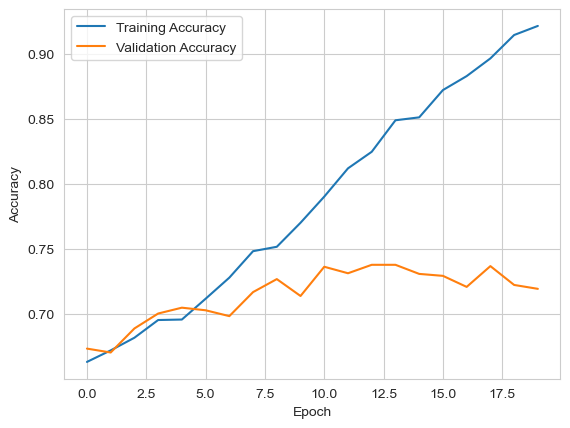

In [91]:
# Set the dataset directory path
directory = "Resources/HAM10000_classified"

# Load the dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",
    seed=123,
    image_size=(224, 224),  # Resize images to match model input (InceptionV3 uses 224x224)
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Data Augmentation (optional)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# Load the InceptionV3 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Define your model architecture using the pre-trained base model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Added more filters
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased number of neurons
    layers.Dropout(0.5),
    layers.Dense(len(train_dataset.class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 5. Increasing epochs from 20 to 30 

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1060s 4s/step - accuracy: 0.6355 - loss: 1.1873 - val_accuracy: 0.6725 - val_loss: 0.9404
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1160s 4s/step - accuracy: 0.6685 - loss: 0.9444 - val_accuracy: 0.6760 - val_loss: 0.9085
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 986s 4s/step - accuracy: 0.6678 - loss: 0.8932 - val_accuracy: 0.6880 - val_loss: 0.8428
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1143s 4s/step - accuracy: 0.6806 - loss: 0.8442 - val_accuracy: 0.7039 - val_loss: 0.7832
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 912s 4s/step - accuracy: 0.6974 - loss: 0.8168 - val_accuracy: 0.7049 - val_loss: 0.8034
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 747s 3s/step - accuracy: 0.7065 - loss: 0.7907 - val_accuracy: 0.7089 - val_loss: 0.7693
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 738s 3s/step - accuracy: 0.7177 - loss: 0.7525 - val_accuracy: 0.7269 - val_loss: 0.7426
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 702s 3s/step - accuracy: 0.7257 - loss: 0.7206 - val_a

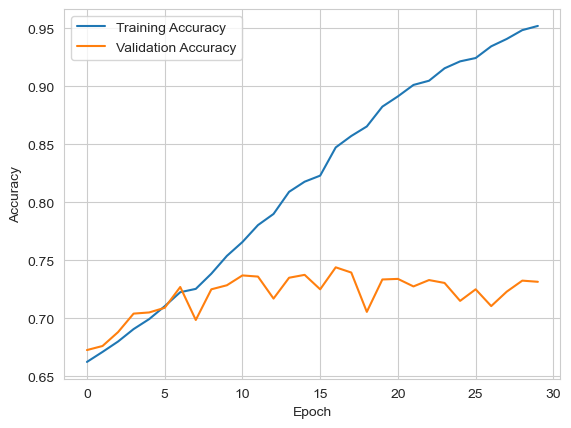

In [159]:
# Set the dataset directory path
directory = "Resources/HAM10000_classified"

# Load the dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",
    seed=123,
    image_size=(224, 224),  # Resize images to match model input (InceptionV3 uses 224x224)
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Data Augmentation (optional)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# Load the InceptionV3 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Define your model architecture using the pre-trained base model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),  # Added more filters
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased number of neurons
    layers.Dropout(0.5),
    layers.Dense(len(train_dataset.class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Pre_Trained Models**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Lesion Type: Melanocytic nevi


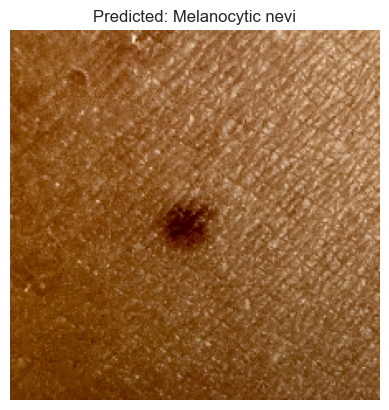

In [165]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt



# Assuming these are the possible lesion types (based on your training dataset)
class_names = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma','Melanocytic nevi', 'Vascular lesions', 'Melanoma']

# Function to preprocess and predict lesion type
def predict_lesion_type(img_path, model):
    # Load the image and resize it to (224, 224) as expected by the model
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a numpy array and normalize the pixel values to (0, 1)
    img_array = image.img_to_array(img) / 255.0

    # Expand dimensions to match the input shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class using the trained model
    prediction = model.predict(img_array)

    # Get the predicted class (index of the highest probability)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map the predicted class index to the class name
    predicted_class_name = class_names[predicted_class]

    # Print the predicted lesion type
    print(f'Predicted Lesion Type: {predicted_class_name}')

    # Optional: Display the image along with the predicted class name
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    return predicted_class_name

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File11.jpg"  # Replace with your image path

# Call the prediction function
predicted_class = predict_lesion_type(img_path, model)
  # Replace with your image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Predicted Lesion Type: Melanocytic nevi


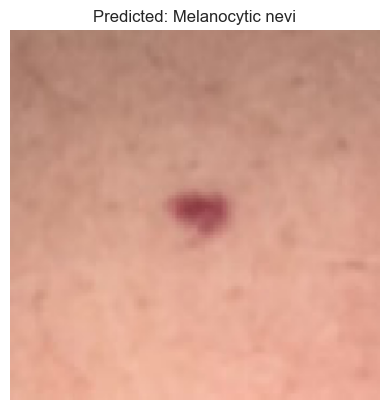

In [166]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt



# Assuming these are the possible lesion types (based on your training dataset)
class_names = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma','Melanocytic nevi', 'Vascular lesions', 'Melanoma']

# Function to preprocess and predict lesion type
def predict_lesion_type(img_path, model):
    # Load the image and resize it to (224, 224) as expected by the model
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a numpy array and normalize the pixel values to (0, 1)
    img_array = image.img_to_array(img) / 255.0

    # Expand dimensions to match the input shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class using the trained model
    prediction = model.predict(img_array)

    # Get the predicted class (index of the highest probability)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map the predicted class index to the class name
    predicted_class_name = class_names[predicted_class]

    # Print the predicted lesion type
    print(f'Predicted Lesion Type: {predicted_class_name}')

    # Optional: Display the image along with the predicted class name
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    return predicted_class_name

# Path to the image you want to test
img_path = "/Users/apple/Documents/PROJECT 4/Test /File12.jpg"  # Replace with your image path

# Call the prediction function
predicted_class = predict_lesion_type(img_path, model)
  # Replace with your image path
